# This notebook classifies naturalized flows from all realizations according to several metrics based on the drought classification in Ault et al. (2014)

In [1]:
import os
import glob
import numpy as np
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import matplotlib
import matplotlib.colors as colors
import copy
import math

Read in **naturalized** historic flows, make annual and convert to metric

In [2]:
historic_flows = np.load('historic_flows.npy')
annual_historic_flows = np.sum(historic_flows, axis=1)*1233.4818/1000000

Calculate mean and standard deviation

In [3]:
mean_flow = np.mean(annual_historic_flows)
st_deviation = np.std(annual_historic_flows)
drought_threshold = mean_flow-0.5*st_deviation

Plot annual flows and show metrics

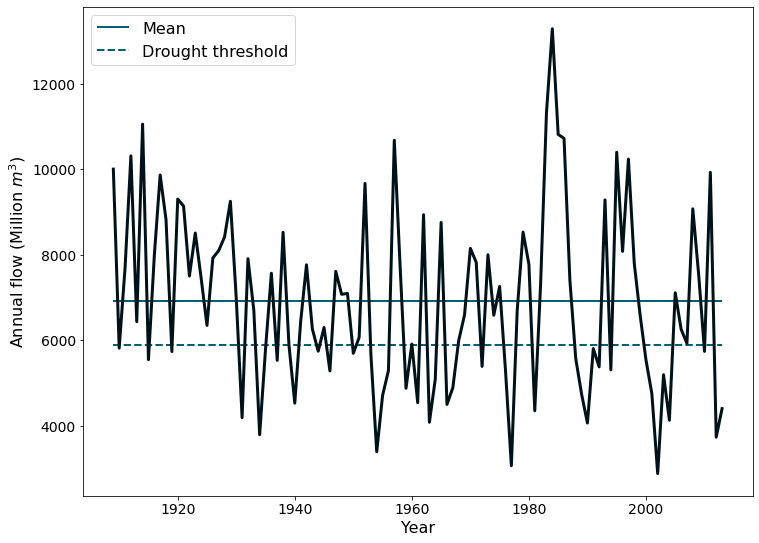

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
ax.plot(np.arange(1909, 2014), annual_historic_flows, linewidth=3, color='#001219')
ax.hlines(y=mean_flow, xmin=1909, xmax=2013, linewidth=2, color='#005F73', label='Mean')
ax.hlines(y=drought_threshold, xmin=1909, xmax=2013, linewidth=2, 
          linestyle='--', color='#005F73', label='Drought threshold')

ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel("Annual flow (Million $m^3$)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=16)

Identify decadal droughts

In [5]:
#script from https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
window_size = 11

i = 0
# Initialize an empty list to store moving averages
moving_averages = []

# Loop through the array to consider
# every window of size 3
while i < len(annual_historic_flows) - window_size + 1:
    # Store elements from i to i+window_size
    # in list to get the current window
    window = annual_historic_flows[i : i + window_size]

    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
    
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
    
    # Shift window to right by one position
    i += 1


Plot windows in flow figure

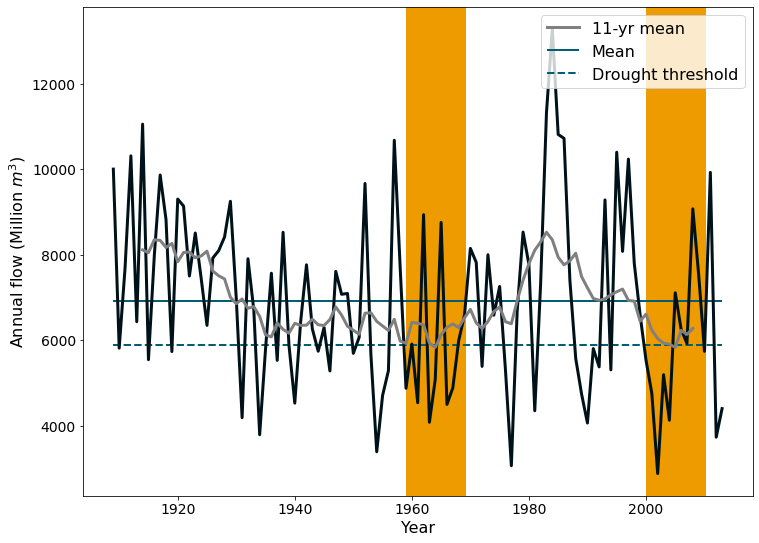

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
ax.plot(np.arange(1909, 2014), annual_historic_flows, linewidth=3, color='#001219')
ax.hlines(y=mean_flow, xmin=1909, xmax=2013, linewidth=2, color='#005F73', label='Mean')
ax.hlines(y=drought_threshold, xmin=1909, xmax=2013, linewidth=2, 
          linestyle='--', color='#005F73', label='Drought threshold')
highlight_years=np.arange(1914, 2009)[moving_averages < drought_threshold]
for year in highlight_years:
    #the window to highlight is +/- 5 years from the identified year crossing the threshold
    ax.axvspan(year-5, year+5, color='#EE9B00') 
ax.plot(np.arange(1914, 2009), moving_averages, linewidth=3, color='grey', label='11-yr mean')

ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel("Annual flow (Million $m^3$)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=16, loc='upper right')

Wrap the above into function to use for all datasets

In [7]:
def drought_identification(timeseries, drought_window, drought_threshold):    
    #Calculate rolling means
    window_size = drought_window
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array to consider
    # every window of size 3
    while i < len(timeseries) - window_size + 1:
        # Store elements from i to i+window_size
        # in list to get the current window
        window = timeseries[i : i + window_size]

        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1
        
    highlight_years=np.arange(drought_window, len(timeseries)+1)[moving_averages < drought_threshold]
    
    #Plot results
    all_years = len(timeseries)
    half_window = math.floor(window_size/2)
    fig, ax = plt.subplots(1, 1, figsize=(12,9))
    ax.plot(np.arange(all_years), timeseries, linewidth=3, color='#001219')
    ax.hlines(y=mean_flow, xmin=0, xmax=len(timeseries), linewidth=2, color='#005F73', label='Mean')
    ax.hlines(y=drought_threshold, xmin=0, xmax=len(timeseries), linewidth=2, 
              linestyle='--', color='#005F73', label='Drought threshold')
    highlight_years=np.arange(half_window, all_years-half_window)[moving_averages < drought_threshold]
    for year in highlight_years:
        #the window to highlight is +/- 5 years from the identified year crossing the threshold
        ax.axvspan(year-half_window, year+half_window, color='#EE9B00') 
    ax.plot(np.arange(half_window, all_years-half_window), 
            moving_averages, linewidth=3, color='grey', label=f'{drought_window}-yr mean')
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel("Annual flow (Million $m^3$)", fontsize=16)
    ax.set_xlabel("Year in realization", fontsize=16)
    ax.legend(fontsize=16, loc='upper right')

Read in flows from stationary sample

In [8]:
stationary_flows = np.load('stationarysynthetic_flows.npy')*1233.4818/1000000
annual_stationary_flows = np.sum(stationary_flows, axis=2)

Edit figure to show both decadal and multi-decadal

In [24]:
def drought_identification_plots(timeseries, drought_threshold, decadal_window=11, multidecadal_window=35):   
    drought_windows=[multidecadal_window, decadal_window]
    drought_colors=[ '#CA6702', '#EE9B00']
    all_years = len(timeseries)

    fig = plt.figure(figsize=(16,9))
    # parameters to specify the width and height ratios between rows and columns
    widths= [1]
    heights = [5, 1]

    gspec = fig.add_gridspec(ncols=1, nrows=2, width_ratios = widths, height_ratios = heights)
    ax = fig.add_subplot(gspec[0,0])
    ax.plot(np.arange(all_years), timeseries, linewidth=3, color='#001219')
    ax.hlines(y=mean_flow, xmin=0, xmax=len(timeseries), linewidth=2, color='#005F73', label='Mean')
    ax.hlines(y=drought_threshold, xmin=0, xmax=len(timeseries), linewidth=2, 
              linestyle='--', color='#005F73', label='Drought threshold')
    
    #Create list to store drought totals
    all_drought_years=[]
    
    for w in range(len(drought_windows)):
        window_size = drought_windows[w]
        #Calculate rolling means for each drought window
        i = 0
        # Initialize an empty list to store moving averages
        moving_averages = []

        # Loop through the array to consider
        # every window of size 3
        while i < len(timeseries) - window_size + 1:
            # Store elements from i to i+window_size
            # in list to get the current window
            window = timeseries[i : i + window_size]

            # Calculate the average of current window
            window_average = round(sum(window) / window_size, 2)

            # Store the average of current
            # window in moving average list
            moving_averages.append(window_average)

            # Shift window to right by one position
            i += 1

        #Plot results
        half_window = math.floor(window_size/2)

        highlight_years=np.arange(half_window, all_years-half_window)[moving_averages < drought_threshold]
        all_drought_years_in_window = []
        for year in highlight_years:
            first_year = year-half_window
            last_year = year+half_window
            #the window to highlight is +/- 5 years from the identified year crossing the threshold
            ax.axvspan(first_year, last_year, color=drought_colors[w]) 
#         ax.plot(np.arange(half_window, all_years-half_window), 
#                 moving_averages, linewidth=3, color='grey', label=f'{window_size}-yr mean')
            all_drought_years_in_window.extend(np.arange(first_year, last_year+1))
    
        all_drought_years.append(set(all_drought_years_in_window))
    # remove decadal drought years that also appear in multidecadal
    all_drought_years[1]=set(all_drought_years[1]) - set(all_drought_years[0])
    # lenght of multidecadal set and then length of decadal set
    total_drought_years = [len(years_list) for years_list in all_drought_years]
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel("Annual flow (Million $m^3$)", fontsize=16)
    ax.set_xlabel("Year in realization", fontsize=16)
    ax.legend(fontsize=16, loc='upper right')
    
    ax2 = fig.add_subplot(gspec[1,:])
    #plot decadal first and then multidecadal
    ax2.barh(1, total_drought_years[1], color = '#EE9B00')
    ax2.barh(1, total_drought_years[0], left = total_drought_years[1], color = '#CA6702')

    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_yticks([])
    ax2.tick_params(axis='x', labelsize=14)
    ax2.set_xlabel("Total years in drought", fontsize=16)
    ax2.set_xlim(ax.get_xlim())
    return(total_drought_years)

[47, 0]

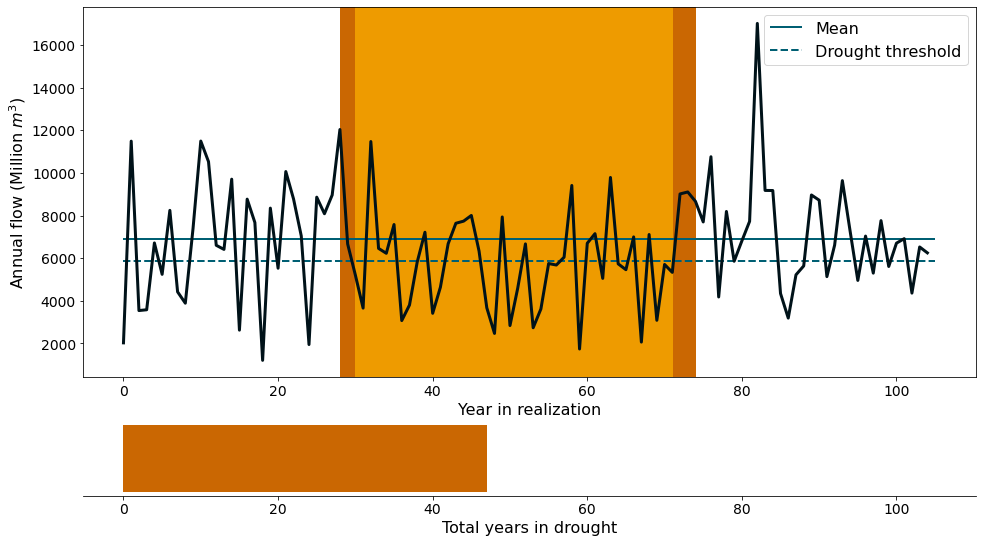

In [63]:
drought_identification_plots(all_annual_experiment_flows[816], drought_threshold)

Edit figure to only calculate totals so we can loop through all realizations to classify

In [26]:
def drought_identification_values_only(timeseries, drought_threshold, decadal_window=11, multidecadal_window=35):   
    drought_windows=[multidecadal_window, decadal_window]
    all_years = len(timeseries)
    
    #Create list to store drought totals
    all_drought_years=[]
    
    for w in range(len(drought_windows)):
        window_size = drought_windows[w]
        #Calculate rolling means for each drought window
        i = 0
        # Initialize an empty list to store moving averages
        moving_averages = []

        # Loop through the array to consider
        # every window of size 3
        while i < len(timeseries) - window_size + 1:
            # Store elements from i to i+window_size
            # in list to get the current window
            window = timeseries[i : i + window_size]

            # Calculate the average of current window
            window_average = round(sum(window) / window_size, 2)

            # Store the average of current
            # window in moving average list
            moving_averages.append(window_average)

            # Shift window to right by one position
            i += 1

        #Plot results
        half_window = math.floor(window_size/2)

        highlight_years=np.arange(half_window, all_years-half_window)[moving_averages < drought_threshold]
        all_drought_years_in_window = []
        for year in highlight_years:
            first_year = year-half_window
            last_year = year+half_window
            all_drought_years_in_window.extend(np.arange(first_year, last_year+1))
    
        all_drought_years.append(list(set(all_drought_years_in_window)))
    # remove decadal drought years that also appear in multidecadal
    all_drought_years[1]=list(set(all_drought_years[1]) - set(all_drought_years[0]))
    # lenght of multidecadal set and then length of decadal set
    total_drought_years = [len(years_list) for years_list in all_drought_years]
    
    return total_drought_years[0], total_drought_years[1], all_drought_years

Read in **naturalized** sampled flows for all realizations

In [27]:
# Read in sampled flows
generated_flows_wider = np.load('LHsamples_wider_100_AnnQonly_flows.npy')
all_annual_experiment_flows=np.sum(generated_flows_wider, axis=2)*1233.4818/1000000
number_of_realizations = len(all_annual_experiment_flows[:,0])
samples = pd.read_csv('LHsamples_wider_100_AnnQonly.txt', header=0, delim_whitespace=True)

Loop through all realizations and calculate drought counts. Store in dataframe. 

In [28]:
droughts_df = pd.DataFrame(index=np.arange(number_of_realizations), 
                           columns=['Decadal counts', 'Multidecadal counts', 'Total counts', 'Drought years'],
                          dtype=object)
for r in range(number_of_realizations):
    droughts_df.at[r, ['Multidecadal counts', 'Decadal counts','Drought years']] = drought_identification_values_only(all_annual_experiment_flows[r,:], 
                                                                                   drought_threshold)

/home/fs02/pmr82_0001/ah986/rival_framings/lib64/python3.6/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


In [38]:
droughts_df['Total counts'] = droughts_df['Multidecadal counts'] + droughts_df['Decadal counts']

Sort based on total droughts

In [39]:
order=np.argsort(droughts_df['Total counts'])[::-1]

droughts_df.to_csv('drought_counts_all_realizations.csv')

In [40]:
order

999    802
998    469
997     49
996     48
995     47
      ... 
4      436
3      459
2      998
1      510
0        0
Name: Total counts, Length: 1000, dtype: int64

Plot all in stacked horizontal bar chart like above

Text(0, 0.5, 'Realization rank')

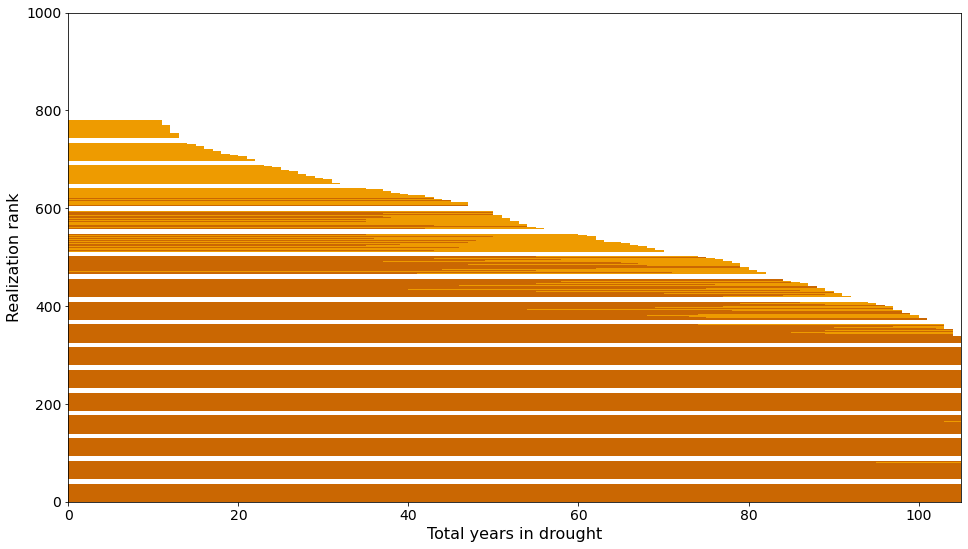

In [41]:
positions = np.arange(number_of_realizations)
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.barh(positions, droughts_df['Multidecadal counts'][order], color='#CA6702')
ax.barh(positions, droughts_df['Decadal counts'][order], left=droughts_df['Multidecadal counts'][order], 
        color='#EE9B00')
ax.set_ylim(0,1000)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel("Total years in drought", fontsize=16)
ax.set_ylabel("Realization rank", fontsize=16)
#plt.savefig('droughts_bar.png')

Wrap the above into function to give you the realization with the **most drought** per dataset

In [42]:
def worst_realization_for_droughts(dataset):
    number_of_realizations = len(dataset[:,0])
    multidecadal_counts=np.zeros(number_of_realizations)
    decadal_counts=np.zeros(number_of_realizations)
    for r in range(number_of_realizations):
        multidecadal_counts[r], decadal_counts[r] = drought_identification_values_only(dataset[r,:], 
                                                                                       drought_threshold)[:2]
    total_counts= multidecadal_counts + decadal_counts
    max_drought_realization = np.argmax(total_counts)
    return [max_drought_realization, 
            multidecadal_counts[max_drought_realization], 
            decadal_counts[max_drought_realization]]

Wrap the above into function to give you the realization with the **median drought** per dataset

In [43]:
def median_realization_for_droughts(dataset):
    number_of_realizations = len(dataset[:,0])
    multidecadal_counts=np.zeros(number_of_realizations)
    decadal_counts=np.zeros(number_of_realizations)
    for r in range(number_of_realizations):
        multidecadal_counts[r], decadal_counts[r] = drought_identification_values_only(dataset[r,:], 
                                                                                       drought_threshold)[:2]
    total_counts= multidecadal_counts + decadal_counts
    median_drought_realization = np.argsort(total_counts)[len(total_counts)//2]

    return [median_drought_realization, 
            multidecadal_counts[median_drought_realization], 
            decadal_counts[median_drought_realization]]

Calculate the total number of droughts same for the worst case of the other experiments (history, synthetic stationary, CMIP5, paleo)
The CMIP5 and Paleo datasets are synthetically generated using the HMM by Julianne Quinn in Quinn et al. (2020)

In [44]:
CMIP_flows = np.load('CMIP_SOWs_flows.npy')[-97*10:,:,:] #Keep only CMIP5 synthetic runs
all_annual_CMIP5_flows=np.sum(CMIP_flows, axis=2)*1233.4818/1000000

In [45]:
paleo_flows = np.load('Paleo_SOWs_flows.npy')
paleo_flows_annual = np.sum(paleo_flows, axis=2)*1233.4818/1000000
np.shape(paleo_flows_annual)

(3660, 105)

In [55]:
median_realization_for_droughts(annual_stationary_flows)

[0, 0.0, 47.0]

In [47]:
worst_realization_for_droughts(paleo_flows_annual)

[406, 97.0, 0.0]

Re-plot horizontal bars with reference annotation

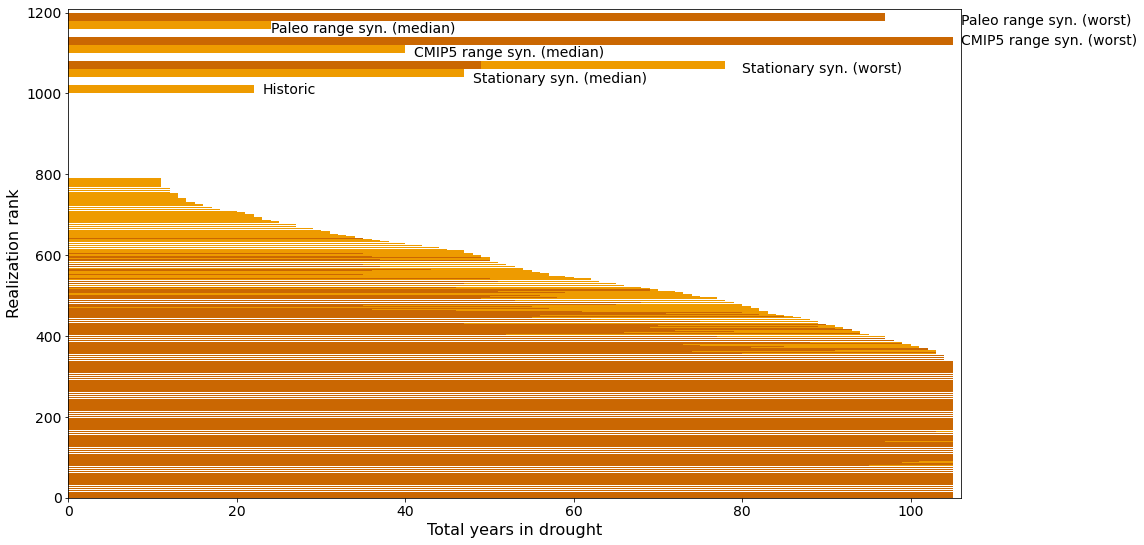

In [49]:
positions = np.arange(number_of_realizations)
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.barh(positions, droughts_df['Multidecadal counts'][order], color='#CA6702')
ax.barh(positions, droughts_df['Decadal counts'][order], left=droughts_df['Multidecadal counts'][order], color='#EE9B00')

# Plot reference bars for history, stationary synthetic and CMIP5
# Adding extra zeros in between to space them out
ax.barh(np.arange(1010, 1210, 20), 
        [0, 0, 0, 49, 0, 0, 105, 0, 0, 97], height=20, color='#CA6702')
ax.barh(np.arange(1010, 1210, 20), 
        [22, 0, 47, 29, 0, 40, 0, 0, 24, 0], height=20, left=[0, 0, 0, 49, 0, 0, 105, 0, 0, 97], color='#EE9B00')

# # Plot dashed annotation lines
# ax.axvline(22, ymin = 0.61, ymax = 0.88, color='k', linestyle='--')
# ax.axvline(47, ymin = 0.53, ymax = 0.91, color='k', linestyle='--')
# ax.axvline(78, ymin = 0.42, ymax = 0.94, color='k', linestyle='--')
# ax.axvline(40, ymin = 0.55, ymax = 0.96, color='k', linestyle='--', zorder=0)

ax.annotate('Historic', (23, 1000), fontsize=14)
ax.annotate('Stationary syn. (median)', (48, 1025), fontsize=14)
ax.annotate('Stationary syn. (worst)', (80, 1050), fontsize=14)
ax.annotate('CMIP5 range syn. (median)', (41, 1090), fontsize=14)
ax.annotate('CMIP5 range syn. (worst)', (106, 1120), fontsize=14)
ax.annotate('Paleo range syn. (median)', (24, 1150), fontsize=14)
ax.annotate('Paleo range syn. (worst)', (106, 1170), fontsize=14)


ax.set_ylim(0,1210)
ax.set_xlim(0,106)

ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel("Total years in drought", fontsize=16)
ax.set_ylabel("Realization rank", fontsize=16)
plt.savefig('droughts_bar.png')

Script to highlight specific realization

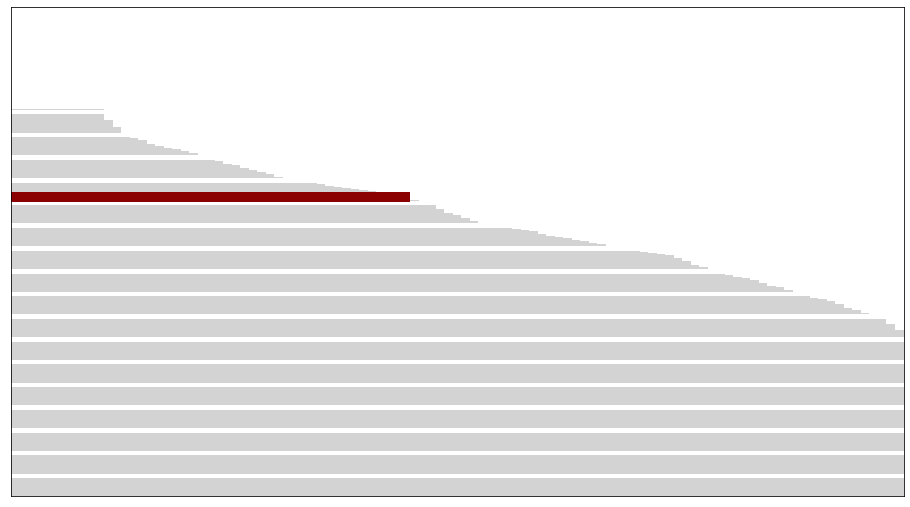

In [64]:
realization_to_highlight=816
position_to_highlight = order[order == realization_to_highlight].index[0]
positions = np.arange(number_of_realizations)

fig, ax = plt.subplots(1, 1, figsize=(16,9))

ax.barh(positions, droughts_df['Multidecadal counts'][order], color='lightgrey')
ax.barh(positions, droughts_df['Decadal counts'][order], left=droughts_df['Multidecadal counts'][order], color='lightgrey')

ax.barh(1000-position_to_highlight, 
        droughts_df.at[realization_to_highlight, 'Total counts'], height=20, color='darkred')

ax.set_ylim(0,1000)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

[]

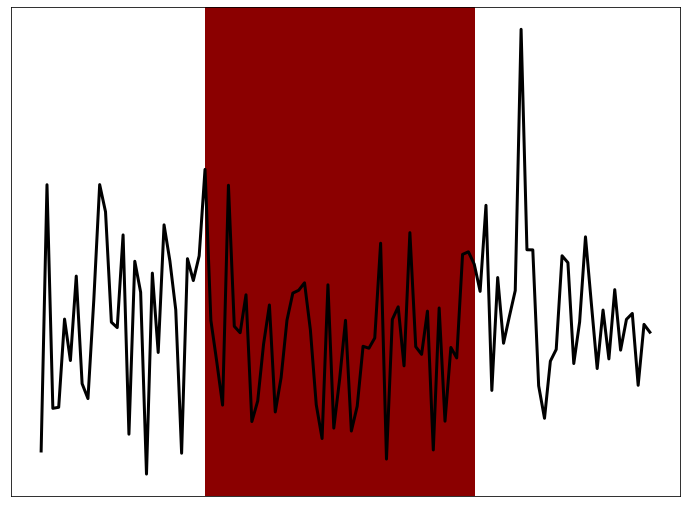

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
flows_to_highlight=all_annual_experiment_flows[realization_to_highlight]
first_year = 28
last_year = 74
highlight_years=np.arange(first_year, last_year)
no_years = 105
ax.plot(np.arange(no_years), flows_to_highlight, linewidth=3, color='black')
ax.axvspan(first_year, last_year, color='darkred') 
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
highlight_years